In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
import math
import pickle
from datetime import datetime
#from numba import cuda 

%matplotlib inline

In [2]:
import sys  
#sys.path.insert(0, '..')

In [3]:
from tiling.read_tiles import TissueDataset, load_color_normalization_values

In [4]:
# Code snippet nvidia gpu
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.8
#config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
HDF5_FOLDER = '/home/sarah/ForthBrainCancer-Dataset/training_CAMELYON16'

In [6]:
train_data = TissueDataset(HDF5_FOLDER,  percentage=0.8, first_part=True, crop_size=256)
val_data = TissueDataset(HDF5_FOLDER, percentage=0.2, first_part=False, crop_size=256)

40
62
40
62


In [7]:
log_dir = "/home/sarah/ForthBrainCancer-Dataset/inception_logs" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [8]:
batch_size_neg=50
batch_size_pos=50
batches_per_train_epoch = 100
batches_per_val_epoch = 50
MAX_EPOCHS = 100

In [9]:
color_normalization_file="CAMELYON16_color_normalization.json"

In [10]:
def history_to_pickle(history, filepath):
    with open(filepath, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
        
def pickle_to_history(filepath):
    history = pickle.load(open(filepath, "rb"))
    return history

In [11]:
def plot_history(history):
    # list all data in history
    print(history.keys())
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for precision
    plt.plot(history['precision'])
    plt.plot(history['val_precision'])
    plt.title('model precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for recall
    plt.plot(history['recall'])
    plt.plot(history['val_recall'])
    plt.title('model recall')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


In [12]:
model = keras.applications.InceptionV3(input_shape=(256,256,3),
                                        include_top=True,
                                        classes = 1,
                                        classifier_activation="sigmoid",
                                        weights=None)

In [13]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [15]:
now1 = datetime.now()
model_type = 'inception_v3'
model_hdf5 = '/home/sarah/ForthBrainCancer-Dataset/inception_logs/model_{}_'.format(model_type) + now1.strftime("%Y%m%d-%H%M%S") + '.ckpt'
filepath = '/home/sarah/ForthBrainCancer-Dataset/inception_logs/{}.pkl'.format(model_type)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_hdf5, monitor='loss',verbose=1, save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                           verbose=1, mode='max', min_lr=1e-5)

#all callbacks
callbacks = [tensorboard_callback, model_checkpoint, reduce_lr]        
history = model.fit(x=train_data.generator(batch_size_neg, batch_size_pos, True, green_layer_only=True, color_normalization_file=color_normalization_file),
                    validation_data=val_data.generator(batch_size_neg, batch_size_pos, False, green_layer_only=True, color_normalization_file=color_normalization_file),
                    epochs=MAX_EPOCHS,
                    steps_per_epoch = batches_per_train_epoch,
                    validation_steps = batches_per_val_epoch,
                    callbacks=callbacks
                   )
dtme = now1.strftime('%m%d%Y_%H%M%S.pkl')
now2 = datetime.now()
print('duration: {} - path: {}'.format(now2 - now1, filepath))
history_to_pickle(history, filepath)

Epoch 1/100
100/100 [==============================] - 2474s 25s/step - loss: 0.2556 - accuracy: 0.8910 - precision: 0.9131 - recall: 0.8604 - val_loss: 0.6985 - val_accuracy: 0.5498 - val_precision: 0.5262 - val_recall: 0.9988

Epoch 00001: loss improved from inf to 0.19517, saving model to /home/sarah/ForthBrainCancer-Dataset/inception_logs/model_inception_v3_20210213-180332.ckpt
INFO:tensorflow:Assets written to: /home/sarah/ForthBrainCancer-Dataset/inception_logs/model_inception_v3_20210213-180332.ckpt/assets
Epoch 2/100
100/100 [==============================] - 2475s 25s/step - loss: 0.1572 - accuracy: 0.9343 - precision: 0.9434 - recall: 0.9241 - val_loss: 1.0728 - val_accuracy: 0.3934 - val_precision: 0.2799 - val_recall: 0.1356

Epoch 00002: loss improved from 0.19517 to 0.15373, saving model to /home/sarah/ForthBrainCancer-Dataset/inception_logs/model_inception_v3_20210213-180332.ckpt
INFO:tensorflow:Assets written to: /home/sarah/ForthBrainCancer-Dataset/inception_logs/model

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])


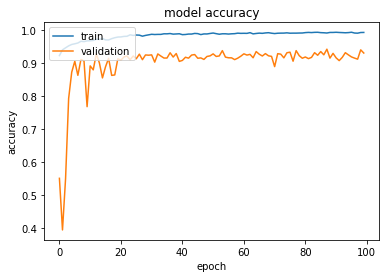

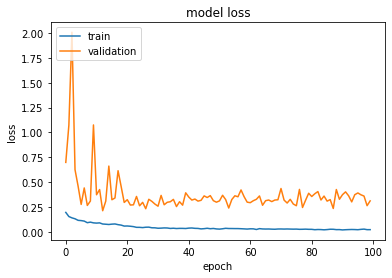

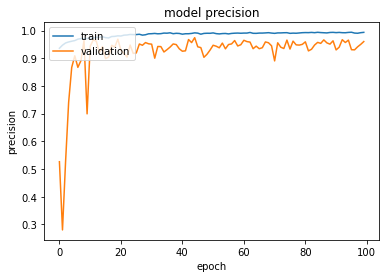

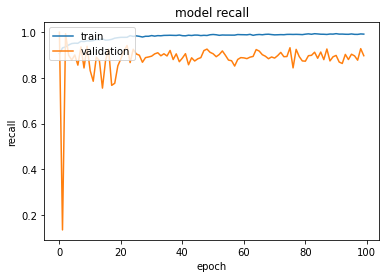

In [16]:
plot_history(history.history)

In [17]:
model.save('/home/sarah/ForthBrainCancer-Dataset/inception_logs/{}.ckpt'.format(model_type))

INFO:tensorflow:Assets written to: /home/sarah/ForthBrainCancer-Dataset/inception_logs/inception_v3.ckpt/assets


### TESTING

In [18]:
HDF5_FOLDER = '/home/sarah/ForthBrainCancer-Dataset/testing_CAMELYON16'

In [19]:
test_data = TissueDataset(HDF5_FOLDER, percentage=0.1, first_part=False, crop_size=256)

81
35


In [20]:
#from tf.keras.models import load_model
#checkpoint_path = '/home/sarah/ForthBrainCancer-Dataset/inception_logs/inception_v3.hdf5'
#model = tf.keras.models.load_model(checkpoint_path, compile=False)

In [21]:
iter_norm = test_data.generator(num_neg=2000, num_pos=2000, data_augm=False, color_normalization_file=None)

In [22]:
i = 0
#Y, Y_pred = list(), list()
for x, y in iter_norm:
    y_pred = model.predict(x)
    i +=1
    if i == 1:
        break

In [23]:
len(y_pred)

4000

In [24]:
y_pred

array([[9.9192441e-01],
       [9.9999809e-01],
       [9.9999642e-01],
       ...,
       [9.9999857e-01],
       [9.9999052e-01],
       [4.7969818e-04]], dtype=float32)

In [25]:
len(y)

4000

In [26]:
y_pred = np.around(y_pred.flatten())
#y_pred = np.around(y_pred.flatten())

In [27]:
y_pred

array([1., 1., 1., ..., 1., 1., 0.], dtype=float32)

In [28]:
np.unique(y)

array([0., 1.])

In [29]:
np.unique(y_pred)

array([0., 1.], dtype=float32)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
print('Confusion Matrix')
print(confusion_matrix(y, y_pred))
print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(y, y_pred))

Confusion Matrix
[[ 140 1860]
 [ 375 1625]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.27      0.07      0.11      2000
         1.0       0.47      0.81      0.59      2000

    accuracy                           0.44      4000
   macro avg       0.37      0.44      0.35      4000
weighted avg       0.37      0.44      0.35      4000



In [32]:
from sklearn.metrics import accuracy_score
print('Accuracy score:')
print(accuracy_score(y, y_pred))

Accuracy score:
0.44125


### Testing with Val set

In [33]:
iter_train = train_data.generator(num_neg=2000, num_pos=2000, data_augm=False, color_normalization_file=None)

In [34]:
i = 0
#Y, Y_pred = list(), list()
for x, y in iter_train:
    y_pred = model.predict(x)
    i +=1
    if i == 1:
        break

In [35]:
y_pred = np.around(y_pred.flatten())

In [36]:
print('Confusion Matrix')
print(confusion_matrix(y, y_pred))
print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(y, y_pred))

Confusion Matrix
[[  62 1938]
 [ 438 1562]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.12      0.03      0.05      2000
         1.0       0.45      0.78      0.57      2000

    accuracy                           0.41      4000
   macro avg       0.29      0.41      0.31      4000
weighted avg       0.29      0.41      0.31      4000



In [37]:
print('Accuracy score:')
print(accuracy_score(y, y_pred))

Accuracy score:
0.406


In [38]:
color_normalization_file="CAMELYON16_color_normalization.json"

In [39]:
m = '/home/sarah/ForthBrainCancer-Dataset/inception_logs/model.hdf5'
#model = tf.keras.models.load_model(m)

In [40]:
#iter_norm = test_data.generator(num_neg=1, num_pos=1, data_augm=False, color_normalization_file=color_normalization_file)

In [41]:
def plot_samples(itera, num_samples=2):
    plt.figure(figsize=(12,4))
    for x, y in itera:
        print(x.shape)
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            plt.tight_layout()
            ax.set_title('Sample #{} - class {}'.format(i, y[i]))
            ax.imshow(x[i])
            ax.axis('off') 
        break # generate yields infinite random samples, so we stop after first

(4000, 256, 256, 3)


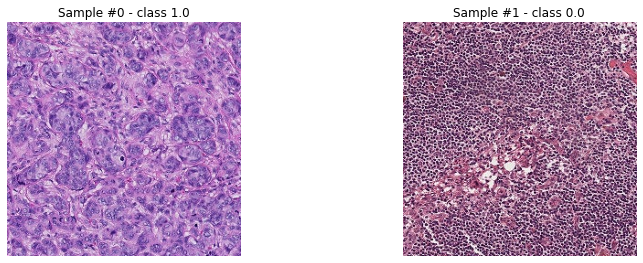

In [42]:
plot_samples(iter_norm, num_samples=2)

In [43]:
i = 0
for x, y in iter_norm:
    pred = model.predict(x)
    y0 = 0 if pred[0]< 0.5 else 1
    y1 = 0 if pred[1]< 0.5 else 1
    print(y, np.array([y0, y1]))
    i +=1
    if i == 1:
        break

[1. 0. 0. ... 1. 1. 0.] [1 1]


In [44]:
from PIL import Image, ImageDraw, ImageFont
def np_to_pil(np_img):
    """
    Convert a NumPy array to a PIL Image.
    Args:
    np_img: The image represented as a NumPy array.

    Returns:
     The NumPy array converted to a PIL Image.
    """
    if np_img.dtype == "bool":
        np_img = np_img.astype("uint8") * 255
    elif np_img.dtype == "float64":
        np_img = (np_img * 255).astype("uint8")
    return Image.fromarray(np_img)

(-0.5, 255.5, 255.5, -0.5)

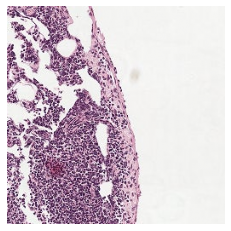

In [45]:
plt.imshow(x[1])
plt.axis('off')

In [46]:
from keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

ModuleNotFoundError: No module named 'keras'

In [ ]:
y_pred

In [ ]:
def build_features_figure(feat_model, path_image):
    # Example of features on the last conv2D layer - 83 according to model.summary
    model = Model(inputs=feat_model.inputs, outputs=feat_model.layers[83].output)
    # load the image with the required shape
    img = image.load_img(path_image, target_size=(224, 224))
    # convert the image to an array
    img = image.img_to_array(img)
    # expand dimensions so that it represents a single 'sample'
    img = np.expand_dims(img, axis=0)
    # prepare the image (e.g. scale pixel values for the vgg)
    img = preprocess_input(img)
    # get feature map for first hidden layer
    feature_maps = model.predict(img)
    # plot all 64 maps in an 8x8 squares
    square = 8
    ix = 1
    f, axs = plt.subplots(2,2,figsize=(15,15))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix-1]) #, cmap='gray')
            ix += 1
    # show the figure
    plt.show()

In [ ]:
build_features_figure(model, '/home/sarah/ForthBrainCancer-Dataset/inception_logs/normal.png')

In [ ]:
build_features_figure(model, '/home/sarah/ForthBrainCancer-Dataset/inception_logs/tumor.png')